# 03. Khai Phá Dữ Liệu - Phân Cụm và Luật Kết Hợp
Notebook này thực hiện phân cụm sinh viên và khai phá luật kết hợp trong dữ liệu hiệu suất học tập.

In [18]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from src.data.loader import DataLoader

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')
%matplotlib inline

## 1. Tải Dữ Liệu

In [19]:
loader = DataLoader()
df = loader.load_combined_data(merge=False)

# Tạo biến phân loại cho phân cụm
df['performance_level'] = df['G3'].apply(lambda x: 'High' if x >= 15 else ('Medium' if x >= 10 else 'Low'))

print(f"Kích thước dữ liệu: {df.shape}")
print(f"Phân bố mức hiệu suất:\n{df['performance_level'].value_counts()}")

Loaded 395 records from student-mat.csv
Loaded 649 records from student-por.csv
Dữ liệu đã nối: 1044 bản ghi tổng cộng
Kích thước dữ liệu: (1044, 35)
Phân bố mức hiệu suất:
performance_level
Medium    610
Low       230
High      204
Name: count, dtype: int64


## 2. Phân Cụm Sinh Viên

In [20]:
# Chọn các đặc trưng cho phân cụm
cluster_features = ['age', 'Medu', 'Fedu', 'studytime', 'failures', 'absences', 'G1', 'G2', 'G3']
X_cluster = df[cluster_features].copy()

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

print(f"Dữ liệu cho phân cụm: {X_cluster_scaled.shape}")

Dữ liệu cho phân cụm: (1044, 9)


## 3. Phân Cụm K-Means với Đánh Giá

In [21]:
# Thử nghiệm với nhiều số lượng cụm
range_n_clusters = [2, 3, 4, 5, 6]
results = []

for n_clusters in range_n_clusters:
    # Phân cụm
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_cluster_scaled)
    
    # Tính các chỉ số đánh giá
    silhouette_avg = silhouette_score(X_cluster_scaled, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(X_cluster_scaled, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_cluster_scaled, cluster_labels)
    
    results.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg,
        'calinski_harabasz_score': calinski_harabasz,
        'davies_bouldin_score': davies_bouldin
    })
    
    print(f"K={n_clusters}: Silhouette={silhouette_avg:.3f}, CH={calinski_harabasz:.3f}, DB={davies_bouldin:.3f}")

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)
print(f"\nBảng đánh giá các mô hình phân cụm:")
print(results_df)

K=2: Silhouette=0.212, CH=313.747, DB=1.723
K=3: Silhouette=0.172, CH=248.506, DB=1.845
K=4: Silhouette=0.178, CH=226.915, DB=1.676
K=5: Silhouette=0.174, CH=204.352, DB=1.568
K=6: Silhouette=0.155, CH=190.177, DB=1.598

Bảng đánh giá các mô hình phân cụm:
   n_clusters  silhouette_score  calinski_harabasz_score  davies_bouldin_score
0           2          0.211609               313.746618              1.723419
1           3          0.172407               248.506233              1.844986
2           4          0.178316               226.915001              1.676313
3           5          0.174240               204.352311              1.568449
4           6          0.154820               190.176879              1.597564


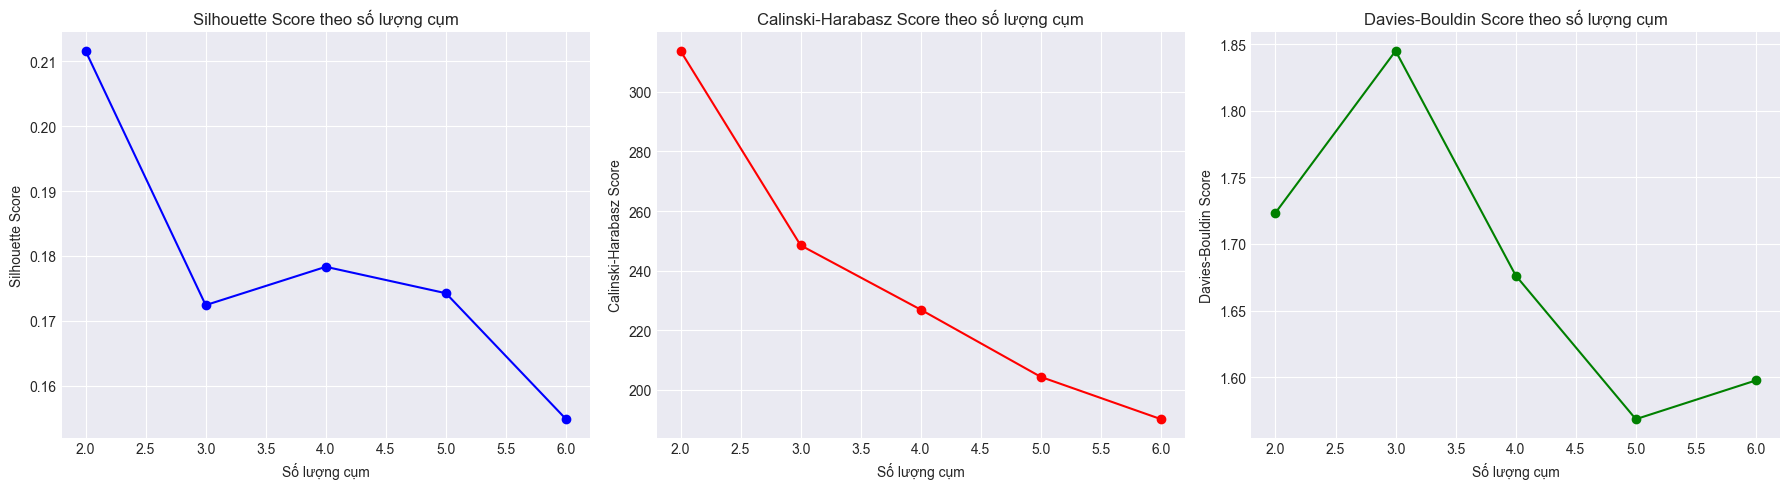

In [22]:
# Trực quan hóa kết quả đánh giá
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(results_df['n_clusters'], results_df['silhouette_score'], 'bo-')
axes[0].set_xlabel('Số lượng cụm')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score theo số lượng cụm')
axes[0].grid(True)

axes[1].plot(results_df['n_clusters'], results_df['calinski_harabasz_score'], 'ro-')
axes[1].set_xlabel('Số lượng cụm')
axes[1].set_ylabel('Calinski-Harabasz Score')
axes[1].set_title('Calinski-Harabasz Score theo số lượng cụm')
axes[1].grid(True)

axes[2].plot(results_df['n_clusters'], results_df['davies_bouldin_score'], 'go-')
axes[2].set_xlabel('Số lượng cụm')
axes[2].set_ylabel('Davies-Bouldin Score')
axes[2].set_title('Davies-Bouldin Score theo số lượng cụm')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [23]:
# Chọn số lượng cụm tốt nhất dựa trên Silhouette Score
best_k = results_df.loc[results_df['silhouette_score'].idxmax(), 'n_clusters']
print(f"Số lượng cụm tối ưu theo Silhouette Score: {best_k}")

# Phân cụm với số lượng cụm tối ưu
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_labels = final_kmeans.fit_predict(X_cluster_scaled)

# Thêm nhãn cụm vào dữ liệu gốc
df['cluster'] = final_labels

Số lượng cụm tối ưu theo Silhouette Score: 2


## 4. Đánh Giá Mô Hình Phân Cụm Cuối Cùng

In [24]:
# Đánh giá mô hình phân cụm cuối cùng
final_silhouette = silhouette_score(X_cluster_scaled, final_labels)
final_calinski = calinski_harabasz_score(X_cluster_scaled, final_labels)
final_davies = davies_bouldin_score(X_cluster_scaled, final_labels)

def silhouette_level(score: float) -> str:
    if score >= 0.5:
        return "tốt"
    if score >= 0.25:
        return "trung bình"
    return "thấp"

def davies_level(score: float) -> str:
    if score <= 1.0:
        return "tốt"
    if score <= 2.0:
        return "trung bình"
    return "thấp"

print("=== ĐÁNH GIÁ PHÂN CỤM (K-MEANS) ===")
print(f"- Số cụm được chọn (theo Silhouette): K = {best_k}")
print(f"- Silhouette Score: {final_silhouette:.3f} → mức {silhouette_level(final_silhouette)} (càng gần 1 càng tốt)")
print(f"- Calinski–Harabasz Score: {final_calinski:.3f} (càng lớn càng tốt; dùng để so sánh tương đối giữa các K)")
print(f"- Davies–Bouldin Index: {final_davies:.3f} → mức {davies_level(final_davies)} (càng nhỏ càng tốt)")

# Quy mô cụm
cluster_sizes = df['cluster'].value_counts().sort_index()
print("\n- Quy mô từng cụm:")
for cid, cnt in cluster_sizes.items():
    print(f"  + Cụm {cid}: {int(cnt):,} sinh viên ({cnt/len(df):.2%})")

# Thống kê cho từng cụm
cluster_stats = df.groupby('cluster')[cluster_features].agg(['mean', 'std']).round(3)
print("\n- Thống kê đặc trưng theo cụm (mean/std):")
print(cluster_stats)

print("\nNhận xét:")
print("- Nếu Silhouette thấp, các cụm có thể chồng lấn; khi đó ưu tiên dùng phân cụm như một công cụ phân nhóm/diễn giải (profiling) hơn là ranh giới cứng")
print("- Các thống kê theo cụm (điểm, vắng mặt, số lần trượt, thời gian học) là cơ sở để diễn giải và gợi ý can thiệp theo nhóm")

Đánh giá mô hình phân cụm cuối cùng (K=2):
- Silhouette Score: 0.212 (càng gần 1 càng tốt)
- Calinski-Harabasz Score: 313.747 (càng lớn càng tốt)
- Davies-Bouldin Score: 1.723 (càng nhỏ càng tốt)

Thống kê cho từng cụm:
            age          Medu         Fedu        studytime        failures  \
           mean    std   mean    std  mean    std      mean    std     mean   
cluster                                                                       
0        16.459  1.132  2.969  1.041  2.72  1.069     2.170  0.864    0.026   
1        17.063  1.288  2.143  1.057  1.97  0.992     1.719  0.721    0.565   

               absences             G1             G2             G3         
           std     mean    std    mean    std    mean    std    mean    std  
cluster                                                                      
0        0.179    3.371  4.419  13.151  2.163  13.321  2.165  13.689  2.212  
1        0.878    5.775  7.708   8.773  1.879   8.632  2.495   8.385  3.

## 5. Trực Quan Hóa Kết Quả Phân Cụm

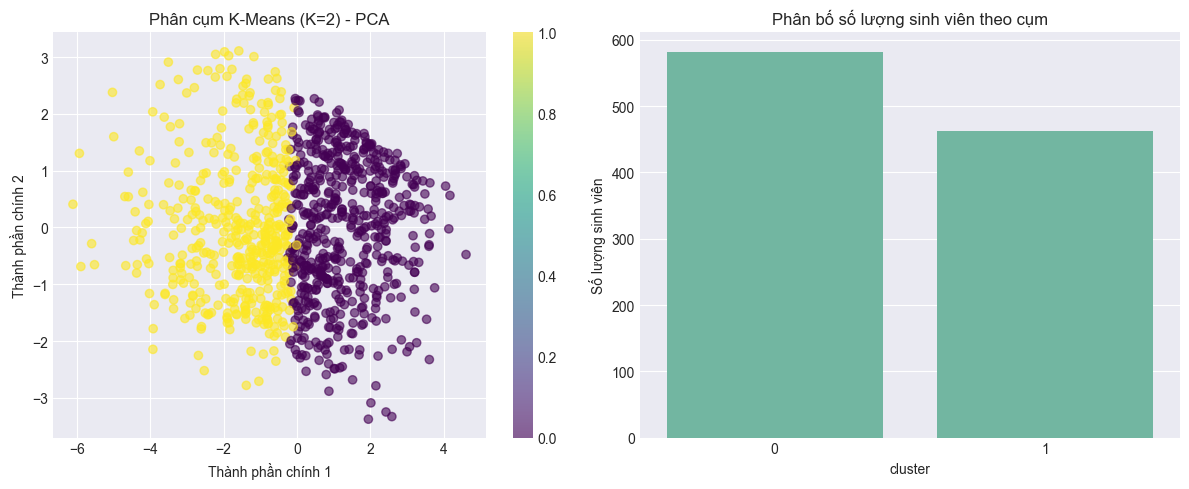

In [25]:
# Giảm chiều dữ liệu để trực quan hóa
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

# Vẽ biểu đồ phân tán
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=final_labels, cmap='viridis', alpha=0.6)
plt.title(f'Phân cụm K-Means (K={best_k}) - PCA')
plt.xlabel('Thành phần chính 1')
plt.ylabel('Thành phần chính 2')
plt.colorbar(scatter)

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='cluster')
plt.title(f'Phân bố số lượng sinh viên theo cụm')
plt.ylabel('Số lượng sinh viên')

plt.tight_layout()
plt.show()

## 6. Phân Tích Đặc Trưng Cụm

In [26]:
# Phân tích đặc điểm từng cụm
print("Phân tích đặc điểm từng cụm:")
for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"\nCụm {cluster_id} ({len(cluster_data)} sinh viên):")
    
    # Thống kê điểm số
    avg_g3 = cluster_data['G3'].mean()
    avg_absences = cluster_data['absences'].mean()
    avg_studytime = cluster_data['studytime'].mean()
    avg_failures = cluster_data['failures'].mean()
    
    print(f"  - Điểm trung bình G3: {avg_g3:.2f}")
    print(f"  - Số ngày nghỉ trung bình: {avg_absences:.2f}")
    print(f"  - Thời gian học trung bình: {avg_studytime:.2f}")
    print(f"  - Số lần thất bại trung bình: {avg_failures:.2f}")
    
    # Tỷ lệ hiệu suất cao/thấp
    perf_dist = cluster_data['performance_level'].value_counts(normalize=True) * 100
    print(f"  - Phân bố mức hiệu suất: {dict(perf_dist.round(2))}%")

Phân tích đặc điểm từng cụm:

Cụm 0 (582 sinh viên):
  - Điểm trung bình G3: 13.69
  - Số ngày nghỉ trung bình: 3.37
  - Thời gian học trung bình: 2.17
  - Số lần thất bại trung bình: 0.03
  - Phân bố mức hiệu suất: {'Medium': np.float64(63.92), 'High': np.float64(34.88), 'Low': np.float64(1.2)}%

Cụm 1 (462 sinh viên):
  - Điểm trung bình G3: 8.39
  - Số ngày nghỉ trung bình: 5.77
  - Thời gian học trung bình: 1.72
  - Số lần thất bại trung bình: 0.56
  - Phân bố mức hiệu suất: {'Medium': np.float64(51.52), 'Low': np.float64(48.27), 'High': np.float64(0.22)}%


## 7. Khai Phá Luật Kết Hợp

In [27]:
# Tạo dữ liệu rời rạc hóa cho luật kết hợp
df_assoc = df.copy()

# Rời rạc hóa một số biến liên tục
df_assoc['studytime_cat'] = pd.cut(df_assoc['studytime'], bins=3, labels=['Low', 'Medium', 'High'])
df_assoc['failures_cat'] = pd.cut(df_assoc['failures'], bins=[-1, 0, 2, 10], labels=['None', 'Few', 'Many'])
df_assoc['absences_cat'] = pd.cut(df_assoc['absences'], bins=[-1, 5, 15, 100], labels=['Low', 'Medium', 'High'])
df_assoc['G3_cat'] = pd.cut(df_assoc['G3'], bins=[-1, 9, 14, 20], labels=['Fail', 'Pass', 'Excellent'])

# Chọn các cột phân loại cho luật kết hợp
assoc_cols = ['school', 'sex', 'studytime_cat', 'failures_cat', 'absences_cat', 'G3_cat']
df_binary = df_assoc[assoc_cols]

print(f"Dữ liệu cho luật kết hợp: {df_binary.shape}")
print(f"Các cột được sử dụng: {list(df_binary.columns)}")

Dữ liệu cho luật kết hợp: (1044, 6)
Các cột được sử dụng: ['school', 'sex', 'studytime_cat', 'failures_cat', 'absences_cat', 'G3_cat']


In [28]:
# Chuyển đổi dữ liệu sang định dạng giỏ hàng cho thuật toán Apriori
def encode_data(df):
    # Chuyển đổi mỗi hàng thành một danh sách các mục
    transactions = []
    for idx, row in df.iterrows():
        transaction = []
        for col in df.columns:
            val = row[col]
            if pd.notna(val):
                transaction.append(f"{col}={val}")
        transactions.append(transaction)
    return transactions

# Mã hóa dữ liệu
transactions = encode_data(df_binary)
print(f"Số lượng giao dịch: {len(transactions)}")
print(f"Ví dụ một giao dịch: {transactions[0]}")

Số lượng giao dịch: 1044
Ví dụ một giao dịch: ['school=GP', 'sex=F', 'studytime_cat=Low', 'failures_cat=None', 'absences_cat=Medium', 'G3_cat=Fail']


In [29]:
# Sử dụng TransactionEncoder để mã hóa dữ liệu
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Dữ liệu sau mã hóa: {df_encoded.shape}")
print(f"Các mục duy nhất: {len(te.columns_)}")

Dữ liệu sau mã hóa: (1044, 16)
Các mục duy nhất: 16


In [30]:
# Áp dụng thuật toán Apriori để tìm các mẫu phổ biến
min_support = 0.1  # Giảm support để có nhiều luật hơn
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

print(f"Các mục phổ biến (min_support={min_support}): {len(frequent_itemsets)}")
print(f"\n10 mục phổ biến đầu tiên:")
print(frequent_itemsets.head(10))

Các mục phổ biến (min_support=0.1): 168

10 mục phổ biến đầu tiên:
    support               itemsets
0  0.195402     (G3_cat=Excellent)
1  0.220307          (G3_cat=Fail)
2  0.584291          (G3_cat=Pass)
3  0.696360     (absences_cat=Low)
4  0.251916  (absences_cat=Medium)
5  0.146552     (failures_cat=Few)
6  0.824713    (failures_cat=None)
7  0.739464            (school=GP)
8  0.260536            (school=MS)
9  0.566092                (sex=F)


In [31]:
# Tạo luật kết hợp từ các mục phổ biến
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

print(f"Số lượng luật kết hợp tìm được: {len(rules)}")
print(f"\nCác luật kết hợp (sắp xếp theo lift giảm dần):")
rules_sorted = rules.sort_values('lift', ascending=False)
print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Số lượng luật kết hợp tìm được: 578

Các luật kết hợp (sắp xếp theo lift giảm dần):
                                   antecedents  \
399             (school=MS, failures_cat=None)   
242                     (studytime_cat=Medium)   
261                         (G3_cat=Excellent)   
58                      (studytime_cat=Medium)   
189                                (school=MS)   
240  (studytime_cat=Medium, failures_cat=None)   
405             (school=MS, failures_cat=None)   
281             (school=MS, failures_cat=None)   
460             (school=MS, failures_cat=None)   
436              (school=MS, absences_cat=Low)   

                                          consequents   support  confidence  \
399                         (sex=F, absences_cat=Low)  0.113027    0.575610   
242                        (failures_cat=None, sex=F)  0.103448    0.666667   
261  (school=GP, failures_cat=None, absences_cat=Low)  0.116858    0.598039   
58                                            (se

## 8. Đánh Giá Luật Kết Hợp

In [32]:
print("=== ĐÁNH GIÁ LUẬT KẾT HỢP (ASSOCIATION RULES) ===")

n_rules = len(rules)
mean_support = float(rules['support'].mean())
mean_conf = float(rules['confidence'].mean())
mean_lift = float(rules['lift'].mean())

print(f"- Tổng số luật tìm được: {n_rules:,}")
print(f"- Support trung bình: {mean_support:.3f}")
print(f"- Confidence trung bình: {mean_conf:.3f}")
print(f"- Lift trung bình: {mean_lift:.3f}")
print(f"- Coverage trung bình (xấp xỉ): {mean_support:.3f}")

# Phân bố lift để đánh giá mức 'hữu ích' so với ngẫu nhiên
lift_gt_1 = int((rules['lift'] > 1.0).sum())
lift_gt_12 = int((rules['lift'] > 1.2).sum())
print("\n- Phân bố lift:")
print(f"  + Số luật có lift > 1.0 (tốt hơn ngẫu nhiên): {lift_gt_1:,} ({lift_gt_1/max(n_rules,1):.2%})")
print(f"  + Số luật có lift > 1.2 (mạnh hơn): {lift_gt_12:,} ({lift_gt_12/max(n_rules,1):.2%})")

# Luật tốt nhất theo lift
best_rule_idx = rules['lift'].idxmax()
best_rule = rules.loc[best_rule_idx]
print("\n- Luật tốt nhất theo Lift:")
print(f"  + Antecedent: {list(best_rule['antecedents'])}")
print(f"  + Consequent: {list(best_rule['consequents'])}")
print(f"  + Support: {best_rule['support']:.3f}")
print(f"  + Confidence: {best_rule['confidence']:.3f}")
print(f"  + Lift: {best_rule['lift']:.3f}")

print("\nNhận xét:")
print("- Lift > 1 cho thấy vế phải xảy ra thường xuyên hơn khi có vế trái (so với nền) → luật có ý nghĩa mô tả mẫu hành vi")
print("- Khi triển khai thực tế, nên ưu tiên luật có (support đủ lớn) và (lift/confidence cao) để tránh kết luận dựa trên mẫu hiếm")

Đánh giá luật kết hợp:
- Tổng số luật tìm được: 578
- Support trung bình: 0.211
- Confidence trung bình: 0.679
- Lift trung bình: 1.041
- Coverage trung bình: 0.211

Luật tốt nhất theo Lift:
  Antecedent: ['school=MS', 'failures_cat=None']
  Consequent: ['sex=F', 'absences_cat=Low']
  Support: 0.113
  Confidence: 0.576
  Lift: 1.441


## 9. Phân Tích Insight Từ Luật Kết Hợp

In [33]:
# Lọc các luật có confidence và lift cao
strong_rules = rules[(rules['confidence'] > 0.7) & (rules['lift'] > 1.2)].sort_values('lift', ascending=False)

print(f"Các luật mạnh (confidence > 0.7 và lift > 1.2): {len(strong_rules)}")
if len(strong_rules) > 0:
    for i, (_, rule) in enumerate(strong_rules.head(5).iterrows()):
        antecedents = ', '.join(list(rule['antecedents']))
        consequents = ', '.join(list(rule['consequents']))
        print(f"\n{i+1}. Nếu {antecedents} thì dẫn đến {consequents}")
        print(f"   Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}")
else:
    print("Không tìm thấy luật nào thỏa mãn điều kiện")

Các luật mạnh (confidence > 0.7 và lift > 1.2): 19

1. Nếu studytime_cat=Medium thì dẫn đến sex=F
   Support: 0.121, Confidence: 0.778, Lift: 1.374

2. Nếu studytime_cat=Medium, failures_cat=None thì dẫn đến sex=F
   Support: 0.103, Confidence: 0.755, Lift: 1.334

3. Nếu school=MS, failures_cat=None thì dẫn đến studytime_cat=Low, absences_cat=Low
   Support: 0.138, Confidence: 0.702, Lift: 1.312

4. Nếu G3_cat=Excellent thì dẫn đến failures_cat=None, absences_cat=Low
   Support: 0.150, Confidence: 0.770, Lift: 1.292

5. Nếu G3_cat=Excellent thì dẫn đến school=GP, failures_cat=None
   Support: 0.157, Confidence: 0.804, Lift: 1.279


## 10. Kết Luận và Insight

In [34]:
print("=== KẾT LUẬN & INSIGHT (TỰ ĐỘNG THEO KẾT QUẢ CHẠY) ===")

# 1) Phân cụm
print("\n1) Phân cụm sinh viên (K-Means):")
print(f"   - K tối ưu theo Silhouette: {best_k}")
print(f"   - Silhouette Score: {final_silhouette:.3f}")
print(f"   - Davies–Bouldin Index: {final_davies:.3f}")
print(f"   - Calinski–Harabasz Score: {final_calinski:.3f}")

# Điểm rủi ro theo cụm (dựa trên G3/failures/absences)
cluster_profile = df.groupby('cluster').agg(
    avg_G3=('G3', 'mean'),
    avg_failures=('failures', 'mean'),
    avg_absences=('absences', 'mean'),
    avg_studytime=('studytime', 'mean'),
    n=('G3', 'size')
).sort_index()

risk_cluster = cluster_profile.sort_values(['avg_G3', 'avg_failures', 'avg_absences'], ascending=[True, False, False]).index[0]
print("\n   - Gợi ý diễn giải theo dữ liệu (profiling):")
print(f"     + Cụm có rủi ro cao (G3 thấp / failures cao / absences cao): Cụm {int(risk_cluster)}")
print(f"       * avg_G3={cluster_profile.loc[risk_cluster,'avg_G3']:.2f}, avg_failures={cluster_profile.loc[risk_cluster,'avg_failures']:.2f}, avg_absences={cluster_profile.loc[risk_cluster,'avg_absences']:.2f}, n={int(cluster_profile.loc[risk_cluster,'n']):,}")

# 2) Luật kết hợp
print("\n2) Luật kết hợp (Association Rules):")
print(f"   - Tổng số luật: {len(rules):,}")
print(f"   - Số luật mạnh (confidence>0.7 & lift>1.2): {len(strong_rules):,}")
print(f"   - Lift tốt nhất: {best_rule['lift']:.3f} (support={best_rule['support']:.3f}, confidence={best_rule['confidence']:.3f})")
print(f"   - Mẫu tốt nhất theo lift:")
print(f"     + Nếu {', '.join(list(best_rule['antecedents']))} → thì {', '.join(list(best_rule['consequents']))}")

# 3) Hàm ý hành động
print("\n3) Hàm ý hành động (actionable insights):")
print("   - Phân cụm có thể dùng để phân tầng sinh viên và thiết kế gói hỗ trợ theo nhóm (tư vấn học tập, theo dõi vắng mặt, phụ đạo)")
print("   - Luật kết hợp cung cấp các quy tắc dễ diễn giải để nhận diện 'mẫu hành vi' gắn với kết quả học tập")
print("   - Khi triển khai, nên ưu tiên: (i) luật có support đủ lớn, (ii) luật có lift/confidence cao, và (iii) kiểm tra lại bằng thống kê/đánh giá định tính")

=== KẾT LUẬN TỪ KHAI PHÁ TRI THỨC ===

1. Phân cụm:
   - Số lượng cụm tối ưu: 2
   - Silhouette Score: 0.212
   - Davies-Bouldin Score: 1.723
   - Các cụm phản ánh các nhóm sinh viên với đặc điểm học tập khác nhau

2. Luật kết hợp:
   - Số luật mạnh tìm được: 19
   - Luật tốt nhất theo Lift: 1.441
   - Có thể sử dụng để phát hiện các mẫu hành vi liên quan đến kết quả học tập

3. Insight kinh doanh:
   - Có thể dùng để phân nhóm sinh viên và đưa ra chiến lược hỗ trợ phù hợp
   - Luật kết hợp có thể giúp xác định các yếu tố ảnh hưởng đến kết quả học tập
   - Dữ liệu cho thấy mối liên hệ giữa thời gian học, số lần thất bại và kết quả cuối kỳ
